# Ecuación de Difusión $\vec{\nabla}^2 u = D\frac{\partial u}{\partial t}$. 


Para resolver la ecuación de difusión vamos a aprovechar parte de lo que hicimos para Laplace.

Aquí debo decir que hay 2 formas de hacerlo, resolver vía diferencias finitas y luego estar cargando con la parte que corresponde al tiempo (parecido a como varios de ustedes resolvieron la ecuación de Poisson), o bien re-interpretando el problema. 

En este notebook, vamos a usar la versión de re-interpretación! 

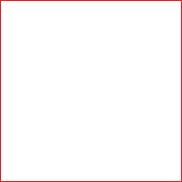

In [1]:
using Plots, Images
placa = load("placa_c.png")  

n * m = 33124


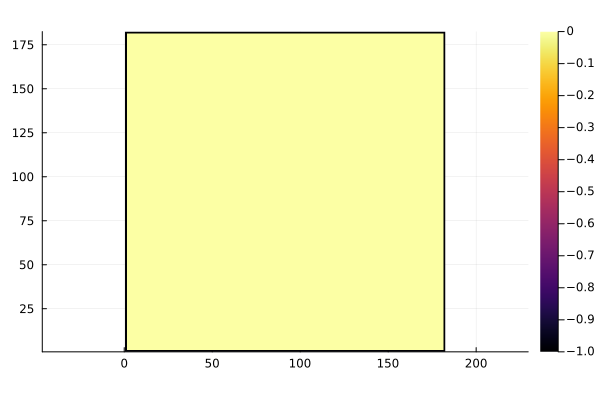

In [2]:
n,m = size(placa)
@show n*m # una placa de 200mil pixeles es ya una placa grande. 
retícula = [placa[n+1-i,j] == placa[1,1] ? -1 : 0 for i in 1:n, j in 1:m];  #vuelve la placa en una retícula de 0's y -1's
heatmap(retícula, aspect_ratio = 1)

In [3]:
function posicion_permitida(i,j, retícula) #regresa true si la posición en la retícula es algo diferente de -1 y false en otro caso
    retícula[i,j] == -1 ? false : true
end

posicion_permitida (generic function with 1 method)

In [4]:
function evoluciona_caminante!(i,j, retícula)#mueve al caminante con igual probabilidad hacia arriba, abajo, izquierda o derecha.
    n = rand(((0,1), (0,-1), (1,0), (-1,0)))
    i += n[1]
    j += n[2]
    return i,j
end 

evoluciona_caminante! (generic function with 1 method)

Hasta aquí todo es igual. 

Ahora podríamos resolverlo descomponiendo la ecuación en diferencias finitas y después reconociendo qué son los caminantes aleatorios. En su lugar vamos a usar un hecho conocido de probabilidad y de la solución a la ecuación de difusión libre (sin frontera).

La solución de la ecuación de difusión comenzando con una delta de dirac, es una guassiana cada vez más aplastada, de hecho, una donde su varianza $\sigma^2$ va como $4D t$ para el caso 2 dimensional. 

Por otro lado, el desplazamiento cuadrático medio de un caminante aleatorio con igual probabilidad de moverse en cualquier dirección es $\langle x^2 \rangle \sim t$, que representa una distribución gaussiana de partículas centrada en el origen y cuya varianza va como $4 p^2 t$. 

Esto implica que para resolver la ecuación de difusión podemos simplemente soltar los caminantes aleatorios desde cada punto de la frontera con las condiciones a la frontera dada. Cada paso de tiempo irá "llenando" el sistema en la forma en la que evolucionaría la ecuación de difusión. Alternativamente, podemos soltar caminantes aleatorios de cada punto del sistema y simplemente cortar la evolución hasta el paso $t$. Si no llegan a la frontera, entonces se promedian como 0. Si llegan, entonces se promedian como $f(x,t)$, donde $f(x,t)$ es la condición a la frontera. 

In [5]:
function trayectoria_hasta_t_o_salir!(i,j,t, retícula) #genera la trayectoria desde el punto de partida, hasta llegar a la frontera (donde la retícula se vuelve -1)
    test = true
    I, J = [i], [j] # comienza la trayectoria en el punto de partida. 
    t0 = 0
    salió = true
    while test 
        t0 += 1
        i,j = evoluciona_caminante!(i,j, retícula) #mueve al caminante
        push!(I, i), push!(J, j) #agrega la nueva posición a la trayectoria
        test = posicion_permitida(i,j, retícula) #revisa si llegó a la frontera
        if t0 == t
            salió = false
            break  # esto es lo único diferente!!
        end
    end
    return I, J, salió 
end 

trayectoria_hasta_t_o_salir! (generic function with 1 method)

In [6]:
function minimo_o_inf(matriz)
    n,m = size(matriz)
    x = Inf
    for i in 1:n, j in 1:m  #busca el mínimo mayor o igual a 0. Si todos son negativos, regresa Inf
        if matriz[i,j]<x && matriz[i,j] >= 0 
            x = matriz[i,j]
        end
    end
    return x
end
function minimum_positivo(matriz) # revisa, entre los valores de la retícula que son mayores o iguales a 0, cual es el menor valor
    x = minimo_o_inf(matriz)
    if x ≠ Inf 
        return x 
    else
        return 0 # si todos los valores en la matriz son negativos, regresa 0. 
    end
end

minimum_positivo (generic function with 1 method)

In [7]:
function imprime_valores(i,j,numero_de_caminantes, contador, pasos)
    if mod(contador, pasos) == 0
        println("revisando vertice ($i ,$j)")
        println("numero maximo de caminantes = $(maximum(numero_de_caminantes[end]))")
        println("numero mínimo de caminantes = $(minimum_positivo(numero_de_caminantes[end]))")
        println(" ")
        flush(stdout)
    end
end

function caminante!(i,j, t,retícula, f, soluciones, numero_de_caminantes)
    test = posicion_permitida(i,j, retícula) # revisa si el caminante está inicialmente en una posición permitida
    if test # si lo está entonces...
        x,y, salió = trayectoria_hasta_t_o_salir!(i,j, t,retícula) #calcula su trayectoria
        s = 0
        if salió
            s = f(x[end], y[end]) # calcula el peso
        end
        if length(x) < t
            for ti in 1:length(x)-2
                for k in 1:ti 
                    numero_de_caminantes[ti][x[k],y[k]] += 1 # suma 1 a todos los vértices por los que pasó
                end
            end
            for ti in (length(x)-1):t
                 for k in 1:(length(x)-1)
                    soluciones[ti][x[k],y[k]] += s #suma ese peso a la posición de todos los vértices por los que pasó.
                    numero_de_caminantes[ti][x[k],y[k]] += 1 # suma 1 a todos los vértices por los que pasó
                end
            end 
        else
            for ti in 1:t
                for k in 1:(length(x)-1)
                    numero_de_caminantes[ti][x[k],y[k]] += 1 # suma 1 a todos los vértices por los que pasó
                end
            end
        end 
    end
    return soluciones, numero_de_caminantes
end

caminante! (generic function with 1 method)

In [8]:
function resuelve_difusión(retícula, t, f, n)    
    contador = 0
    n1, n2 = size(retícula)
    soluciones = [zeros(n1,n2) for i in 1:t]
    
    numero_de_caminantes =  [[retícula[i,j]<0 ? -1 : 0 for i in 1:n1, j in 1:n2] for i in 1:t] # asegura que la retícula sean sólo 0's y 1's
    while minimum_positivo(numero_de_caminantes[end])<n
        for i in 1:n1, j in 1:n2
            contador += 1
            imprime_valores(i,j,numero_de_caminantes, contador, 5000) #imprime los valores cada 5000 pasos para saber qué tan avanzado va el cálculo
            soluciones, numero_de_caminantes = caminante!(i,j, t,retícula, f, soluciones, numero_de_caminantes)
            if minimum_positivo(numero_de_caminantes[end])>n
                break
            end
        end
    end
    return soluciones, numero_de_caminantes
end

resuelve_difusión (generic function with 1 method)

In [9]:
function mezcla_solucion_n(s, nc)  # Esta función simplemente sirve para hacer los promedios de la solución correctamente. 
    n,m = size(s)
    [nc[i,j] > 0 ? s[i,j]/nc[i,j] : NaN for i in 1:n, j in 1:m]
end

mezcla_solucion_n (generic function with 1 method)

In [10]:
f(y,x) = (x^2+y^2)
t = 2000
@time soluciones, numero_de_caminantes = resuelve_difusión(retícula, t, f, 10);

revisando vertice (28 ,86)
numero maximo de caminantes = 837
numero mínimo de caminantes = 0
 
revisando vertice (55 ,172)
numero maximo de caminantes = 1596
numero mínimo de caminantes = 0
 
revisando vertice (83 ,76)
numero maximo de caminantes = 2157
numero mínimo de caminantes = 0
 
revisando vertice (110 ,162)
numero maximo de caminantes = 2330
numero mínimo de caminantes = 0
 
revisando vertice (138 ,66)
numero maximo de caminantes = 2340
numero mínimo de caminantes = 0
 
revisando vertice (165 ,152)
numero maximo de caminantes = 2340
numero mínimo de caminantes = 3
 
revisando vertice (11 ,56)
numero maximo de caminantes = 2351
numero mínimo de caminantes = 7
 
revisando vertice (38 ,142)
numero maximo de caminantes = 2873
numero mínimo de caminantes = 7
 
revisando vertice (66 ,46)
numero maximo de caminantes = 3973
numero mínimo de caminantes = 7
 
revisando vertice (93 ,132)
numero maximo de caminantes = 4331
numero mínimo de caminantes = 7
 
revisando vertice (121 ,36)
numer

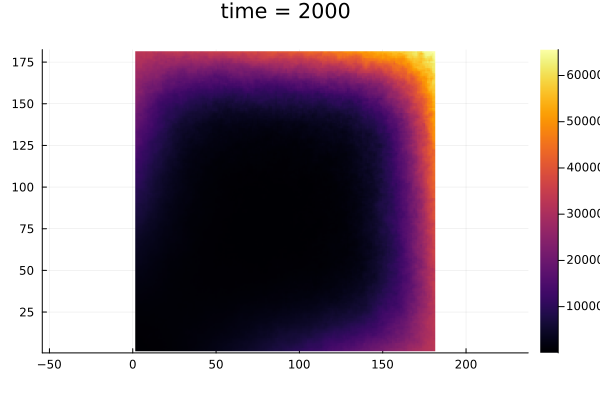

[ Info: Saved animation to D:\Cursos\Simulaciones en Física Estadística\tmp.gif


Plots.AnimatedGif("D:\\Cursos\\Simulaciones en Física Estadística\\tmp.gif")
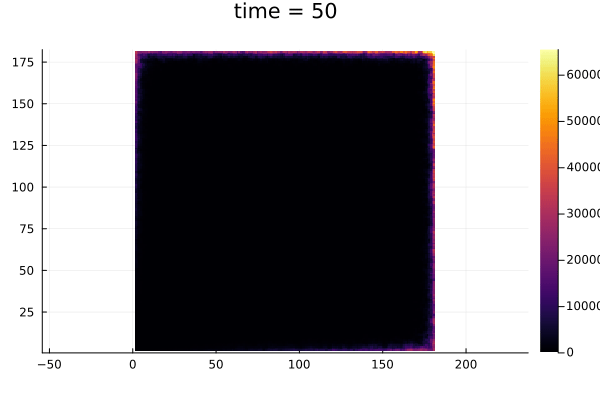

In [12]:
@gif for i in 50:50:length(soluciones)   
     ss = mezcla_solucion_n(soluciones[i], numero_de_caminantes[i])
     heatp = heatmap(numero_de_caminantes[i], aspect_ratio = :equal)
     heatT = heatmap(ss, aspect_ratio = :equal, show = :ijulia, title = "time = $i")
end

# Ecuación de onda

No les voy a resolver la ecuación (eso ya sería demasiado), pero les voy a dar la teoría para hacerlo. Igual que la ecuación de difusión, podemos utilizar la solución de la ecuación de onda general, o bien resolver la ecuación en diferencias finitas y cargar con la parte temporal. La ecuación en diferencias finitas que les conviene es:   

$$ u(x+1, y, t)+u(x-1, y, t)+u(x, y+1, t)+u(x, y-1, t)- 4u(x,y,t) = u(x,y,t)+u(x,y,t-2)-2u(x,y,t-1)$$

esto ya en su versión discreta! Despejando $u(x,y,t)$ tenemos

$$u(x,y,t) =  \frac{u(x+1, y, t)+u(x-1, y, t)+u(x, y+1, t)+u(x, y-1, t)+u(x,y,t-1)}{5}+ \frac{u(x,y,t-1) -u(x,y,t-2)}{5} $$

Noten que en esta versión, sólo se puede ir "hacia adelante" en el tiempo o moverse en el mismo plano temporal, pero no se puede ir hacia atrás. Separé aquí el caminante en la probabilidad de moverse hacia adelante en el tiempo o en cualquier dirección + la velocidad en el tiempo atrás. 

Parte de lo importante aquí, es que puede haber existencias "negativas". También es importante que al llegar una pared reflejante $\dot{u}$ se tiene que multiplicar por $-1$. Entonces, el caminante debe tener la propiedad de "existencia" con la que viaja. Esa existencia varía entre $-1$ y $1$ y depende de la tasa de las partículas en su posición en un tiempo anterior. Así que con cada caminante se debe actualizar la existencia de todos los demás usando la tasa de partículas un tiempo anterior. 
